In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import quantecon as qe # all packages is installed if choose anaconda solution except quantecon
# which can be obtained by pip install commend
import numpy as np
from numba import jit
from numpy.random import normal, uniform
from scipy import special
from datetime import datetime as dt
import pandas as pd
from scipy import integrate
from scipy.optimize import minimize, minimize_scalar
from mpl_toolkits.mplot3d import Axes3D
import collections

In [2]:
"""
In this project, we are going to implement an algorithm of
Bayesian estimation for Discrete Choice Dynamic Programming models
following Imai et al. (2009), Norets (2009), and Ishihara and Ching (2016), 
where the formulation of recursive likelihood is based on Reich (2018).

The simulation is based on the classicial bus engine replacement problem by Rust (1987).
But as Norets (2009), we assume the unobserved variable (which can be thought as the quality)
follow an AR(1) process.

For simplicity, our only parameter of interest is \theta, the marginal cost for additional mile of driving

We first do a brute-force two step procedure, similar to Rust (1987), but substitute the outer
maximization loop for MLE with MCMC for Bayesian estimation.

Then, we consider the integrated approach, which uses past result to approximate the expected value function


"""


beta  = 0.9
rc    = 15.0
theta = 0.5
rho   = 0.7
sigma = 1.0

N_x, N_e0, N_e1 = 10, 10, 10
N_t = 5000
tol = 1e-6


def Epsilon(x, N):
    beta, rc, theta, rho, sigma = x
    sigma_z = sigma/(1-rho**2)**0.5
    Eps = np.zeros(N+1)
    for i_eps in range(N+1):
        Eps[i_eps] = sigma_z * special.ndtri(i_eps/N)
    return Eps

@jit(nopython=True)
def norm_pdf(x):
    return np.exp(-x**2/2)/(2*np.pi)**0.5
@jit(nopython=True)
def Z(x, Eps):
    beta, rc, theta, rho, sigma = x
    sigma_z = sigma/(1-rho**2)**0.5
    N = len(Eps)-1
    Z = np.zeros(N)
    for i in range(N):
        Z[i] = N * sigma_z * (norm_pdf(Eps[i]/sigma_z) - norm_pdf(Eps[i+1]/sigma_z))
    return Z

def AddaCooper(x, N):
    beta, rc, theta, rho, sigma = x
    sigma_z = sigma/(1-rho**2)**0.5
    Eps = Epsilon(x, N)
    ZZ = Z(x, Eps)
    PPi = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            temp = integrate.quad(lambda t: np.exp(-t**2/(2*sigma_z**2)) * (special.ndtr((Eps[j+1]-rho*t)/sigma)
                                                                          -special.ndtr((Eps[j]-rho*t)/sigma)),
                                                                          Eps[i], Eps[i+1])[0]
            PPi[i, j] = temp * N /(2*np.pi*sigma_z**2)**0.5
    return ZZ, PPi

def solveStationary(A):
    """ x = xA where x is the answer
    x - xA = 0
    x( I - A ) = 0 and sum(x) = 1
    """
    n = A.shape[0]
    a = np.eye( n ) - A
    a = np.vstack( (a.T, np.ones( n )) )
    b = np.matrix( [0] * n + [ 1 ] ).T
    return np.linalg.lstsq( a, b )[0]


x = (beta, rc, theta, rho, sigma)
ZZ, PPi = AddaCooper(x, N_e0)
ssd = solveStationary(PPi)
ssd = ssd.reshape(N_e0)
ssd = np.array(ssd)[0]
ZZ1 = ZZ * (1-rho**2)**0.5
ssd

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [3]:
VF_old = np.ones((N_x, N_e0, N_e1))*-100
PF_old = np.zeros((N_x, N_e0, N_e1))
@jit(nopython=True)
def update_VF_PF(VF_old, PF_old, theta):
    VF_new = VF_old.copy()
    PF_new = PF_old.copy()
    for i_x in np.arange(0, N_x)[::-1]:
        for i_e0 in range(N_e0):
            if i_x == N_x-1:
                for i_e1 in range(N_e1):
                    temp1 = -rc + beta*ssd@VF_old[0]@ssd
                    VF_new[i_x, i_e0, i_e1] = temp1 + ZZ1[i_e1]
                    PF_new[i_x, i_e0, i_e1] = 1
            else:
                for i_e1 in range(N_e1):
                    EVF = PPi[i_e0]@VF_old[i_x+1]@ssd
                    temp0 = -(i_x+1) * theta + beta * EVF + ZZ[i_e0]
                    temp1 = -rc + beta*ssd@VF_old[0]@ssd+ ZZ1[i_e1]
                    if temp0 < temp1:
                        VF_new[i_x, i_e0, i_e1] = temp1
                        PF_new[i_x, i_e0, i_e1] = 1
                    else:
                        VF_new[i_x, i_e0, i_e1] = temp0
                        PF_new[i_x, i_e0, i_e1] = 0
    return VF_new, PF_new

def iter_VF_PF(VF_old, PF_old, theta):
    for i_iter in range(200):
        err = 0
        VF_new, PF_new = update_VF_PF(VF_old, PF_old, theta)
        for i_x in range(N_x)[::-1]:
            for i_e0 in range(N_e0):
                for i_e1 in range(N_e1):
                    err += abs(VF_new[i_x, i_e0, i_e1] - VF_old[i_x, i_e0, i_e1])
        #print(i_iter, err)
        if err < tol:
            break
        else:
            VF_old = VF_new
            PF_old = PF_new 
    return VF_new, PF_new


def gen_obs(N_t, PF_old, theta):
    mc = qe.MarkovChain(PPi)
    sim_ix  = [0]
    sim_ie0 = [qe.DiscreteRV(ssd).draw(k=1)[0]]
    sim_ie1 = [qe.DiscreteRV(ssd).draw(k=1)[0]]

    for t in range(1, N_t):
        decision = PF_old[sim_ix[t-1], sim_ie0[t-1], sim_ie1[t-1]]
        if decision == 0:
            sim_ix.append(sim_ix[t-1]+1)
            sim_ie0.append(mc.simulate(ts_length=2, init=sim_ie0[t-1])[1])
            sim_ie1.append(qe.DiscreteRV(ssd).draw(k=1)[0])
        else:
            sim_ix.append(0)
            sim_ie0.append(qe.DiscreteRV(ssd).draw(k=1)[0])
            sim_ie1.append(qe.DiscreteRV(ssd).draw(k=1)[0])

    #plt.hist(sim_ix, bins='auto')
    data = collections.Counter(sim_ix)
    data = dict(data)
    #print(data)
    array = np.array(list(data.items()), dtype=int)
    nmax = np.max(array, axis=0)[0]
    addi = np.vstack((np.arange(nmax+1, N_x+1), np.zeros(N_x-nmax-1+1))).T
    array = np.append(array, addi, axis=0)
    df = pd.DataFrame(array, columns=['milage', 'obs'])
    df['rep'] = -df['obs'].diff()
    df = df.fillna(0)
    ret_obs = df.rep.values
    ret_obs = ret_obs[1:]
    return ret_obs

def log_ret_probs(PF_old):
    inv_PF = PF_old.copy()
    for i in range(len(inv_PF)):
        inv_PF[i] = np.ones((N_e0, N_e1)) - PF_old[i]
    prob_ret = np.zeros(len(inv_PF))
    pnot_ret= PF_old.copy()
    pnot_ret[0] = np.ones((N_e0, N_e1))/(N_e0*N_e1)
    prob_ret[0] = 1 - np.sum(pnot_ret[0])
    #IMPORTANT: 
    #the dist of epsilon_0 for x = 0 is NOT uniform! 
    for i in range(1, len(inv_PF)):
        new_mat = np.sum(pnot_ret[i-1], axis=1)
        new_mat = new_mat.reshape((N_e0, 1))
        updated = np.transpose(PPi) @ new_mat
        expand  = np.repeat(updated, N_e1, axis=1)/N_e1
        not_ret = inv_PF[i] * expand
        ret     = PF_old[i] * expand
        prob_ret[i] = max(np.sum(ret), 1e-16)
        pnot_ret[i] = not_ret
    return np.log(prob_ret)

    
@jit
def log_theta(theta):
    VF_old = np.ones((N_x, N_e0, N_e1))*-100
    PF_old = np.zeros((N_x, N_e0, N_e1))
    VF_old, PF_old = iter_VF_PF(VF_old, PF_old, theta=theta)
    log_probs = log_ret_probs(PF_old)
    value = log_probs @ ret_obs
    print(theta, -value)
    return -value


In [224]:
thetas = np.linspace(0.2, 1.2, 1)
theta_hats = np.zeros(1)
deviations = np.zeros(1)
for i in range(1):
    VF_old, PF_old = iter_VF_PF(VF_old, PF_old, theta=thetas[i])
    ret_obs = gen_obs(N_t, PF_old, thetas[i])
    res = minimize_scalar(log_theta, bounds=(0.1, 1.9), method='bounded')
    theta_hats[i] = res.x
    deviations[i] = np.abs(1 - theta_hats[i]/ thetas[i])
print(deviations)

0.7875388202501891 1645.0604613851094
1.2124611797498104 13636.520697340873
0.5249223594996213 910.456651517608
0.6184063814196586 1099.5986959080399
0.36261646075056775 706.3097280514704
0.23361567975671493 645.1652283085739
0.21003610934952258 644.3266749843219
0.21563760985822908 644.3266749843219
0.21283685960387583 644.3266749843219
0.2117670682007128 644.3266749843219
0.21110590075268562 644.3266749843219
0.2106972767975498 644.3266749843219
0.21044473330465843 644.3266749843219
0.21028865284241394 644.3266749843219
0.21019218981176704 644.3266749843219
0.21013257238016944 644.3266749843219
0.21009572678112015 644.3266749843219
0.21007295494857184 644.3266749843219
0.21005888118207086 644.3266749843219
0.21005018311602353 644.3266749843219
0.21004480741556988 644.3266749843219
0.2100414709667686 644.3266749843219
[0.05020735]


In [4]:
"""
Now, consider bayesian estimation

first, generate a sample of observations

"""
theta = 0.5
VF_old, PF_old = iter_VF_PF(VF_old, PF_old, theta=theta)
ret_obs = gen_obs(N_t, PF_old, theta)
print(log_ret_probs(PF_old))

def sample_lik(ret_obs, theta):
    VF_old = np.ones((N_x, N_e0, N_e1))*-100
    PF_old = np.zeros((N_x, N_e0, N_e1))
    VF_old, PF_old = iter_VF_PF(VF_old, PF_old, theta=theta)
    log_probs = log_ret_probs(PF_old)
    sum_logs = log_probs @ ret_obs
    return sum_logs
def ratio_like(ret_obs, theta0, theta1):
    lik0 = sample_lik(ret_obs, theta0)
    lik1 = sample_lik(ret_obs, theta1)
    return np.exp(lik1 - lik0)
ratio_like(ret_obs, 0.5, 0.51)

[-36.73680057 -36.84136149 -36.84136149  -3.5065579   -2.66628736
  -2.11551718  -1.81050071  -1.64472587  -1.6585109   -1.45732109]


0.14528662248684932

In [9]:
N_mc = 10000
mc_theta = np.ones(N_mc)*0.4
for i in range(1, N_mc):
    theta0 = mc_theta[i-1]
    theta1 = theta0 + 0.01*np.random.normal()
    ratio = ratio_like(ret_obs, theta0, theta1)
    if ratio >= 1:
        mc_theta[i] = theta1
    else:
        if np.random.uniform() <= ratio:
            mc_theta[i] = theta1
        else:
            mc_theta[i] = theta0
    print(mc_theta[i])

0.4
0.39879123370991654
0.39879123370991654
0.4051491443495482
0.41741273017341024
0.41741273017341024
0.4250765534021717
0.42793792173882594
0.42793792173882594
0.4453227740143444
0.4453227740143444
0.43095994620526823
0.43095994620526823
0.43095994620526823
0.44283841816069663
0.4407089197000599
0.4407089197000599
0.4407089197000599
0.4541071776565885
0.4541071776565885
0.4541071776565885
0.46210078371879826
0.4788466561091406
0.4810688418963037
0.4810688418963037
0.4729874937020347
0.47417210775524926
0.47417210775524926
0.48082374442424425
0.4828461030534746
0.4864931455707166
0.47823008443380677
0.47823008443380677
0.47085934598112494
0.4717488576457041
0.4773798280519616
0.4773798280519616
0.4922197502520729
0.49544727589160065
0.4952756557645805
0.5052790363432522
0.5052790363432522
0.5052790363432522
0.49701389007506336
0.49701389007506336
0.49701389007506336
0.49701389007506336
0.4972198453504223
0.4972198453504223
0.4972198453504223
0.4972198453504223
0.48779346038326343
0.48

0.5008981759877659
0.5008981759877659
0.499688339470914
0.4978828924670007
0.4978828924670007
0.4999695563958894
0.4999695563958894
0.4999695563958894
0.4999695563958894
0.4963747648887875
0.4960766514010177
0.4960766514010177
0.4960766514010177
0.4960766514010177
0.4960766514010177
0.49534096006897166
0.49534096006897166
0.5070350901659938
0.49623557298310644
0.49623557298310644
0.49623557298310644
0.482366929234106
0.482366929234106
0.475193558185769
0.48507219046135813
0.5005009402980258
0.5005009402980258
0.5005009402980258
0.4910317596839715
0.4856557548328544
0.49178415372764
0.4835843424221146
0.47403531861297943
0.47403531861297943
0.48488589044513175
0.5025758886126243
0.5025758886126243
0.4996953825377561
0.4996953825377561
0.4996953825377561
0.4996953825377561
0.5040196977794923
0.5040196977794923
0.5051209328158279
0.5005414114545584
0.5026635708336469
0.5026635708336469
0.504234460747605
0.504234460747605
0.5066786620450028
0.5066786620450028
0.5066786620450028
0.496211075

0.49701684820584363
0.49701684820584363
0.49701684820584363
0.5016905439655895
0.5016905439655895
0.4989293530711252
0.509535307374893
0.5079984367107276
0.5229291311052068
0.5224415488749058
0.5224415488749058
0.5224415488749058
0.5224415488749058
0.5115162082537679
0.5164244818729201
0.507819982549595
0.507819982549595
0.507819982549595
0.507056345744389
0.5054296296188369
0.49663122814869
0.5040973296459206
0.5040973296459206
0.5040973296459206
0.5040973296459206
0.49965124190943716
0.49965124190943716
0.4967587178256896
0.4967587178256896
0.4967587178256896
0.4967587178256896
0.5061756913098758
0.5040944570821115
0.5040944570821115
0.5040944570821115
0.5048453731984514
0.5112015370223572
0.5127658359597943
0.5135857332226269
0.5133050711666387
0.514789758517378
0.5301795914923618
0.5301795914923618
0.5301795914923618
0.5234616309348614
0.5234616309348614
0.5215719101700543
0.5215719101700543
0.5215719101700543
0.5215719101700543
0.5215719101700543
0.5215719101700543
0.4962455103510

0.5055301161423695
0.5055301161423695
0.5055301161423695
0.49182126022579614
0.4942684872771703
0.4979208126829686
0.4940300124219341
0.4940300124219341
0.5096810582091935
0.5062018979990303
0.5062018979990303
0.4941064707819872
0.4830922052502139
0.48799904684680623
0.5058752329409799
0.5058752329409799
0.5058752329409799
0.5027294565446155
0.5027294565446155
0.5027294565446155
0.5027294565446155
0.5027294565446155
0.504583333709057
0.504583333709057
0.504583333709057
0.504583333709057
0.504583333709057
0.504583333709057
0.5041375697917237
0.5046621737861924
0.5006533162882131
0.500283662984052
0.4981283390526823
0.49490557552525993
0.4985404246496134
0.4985404246496134
0.5042507579501846
0.5042507579501846
0.5042507579501846
0.5071389434735247
0.49778930225784884
0.5008091366920957
0.4997680818592886
0.4997680818592886
0.4997680818592886
0.4925858886748471
0.4925858886748471
0.49367454607635813
0.49367454607635813
0.479857868560988
0.4977945156196565
0.4977945156196565
0.497794515619

0.4763322101505708
0.47503154814100795
0.47503154814100795
0.47155337956199617
0.4857283313370729
0.48831211671617797
0.4920973132090915
0.4920973132090915
0.4994863721240975
0.4994863721240975
0.4994863721240975
0.49363305781161687
0.49363305781161687
0.4932296563553156
0.4893677648067895
0.5017074199626536
0.5017074199626536
0.49966328083517997
0.4997093331633045
0.49664666721077255
0.4969042442968669
0.4969042442968669
0.4969042442968669
0.4969042442968669
0.4969042442968669
0.49538416272266705
0.4936985087517255
0.4936985087517255
0.4936985087517255
0.4974365213252652
0.49881919931950963
0.5001280754426628
0.4984195420259366
0.5004707051062964
0.5027103312887073
0.5027103312887073
0.5027103312887073
0.4990022793826302
0.4990022793826302
0.5032313854725033
0.5021062884167481
0.5032926041209453
0.527340470881678
0.5281756682200671
0.5004257298820275
0.494656645273767
0.49556547705639115
0.5006180706927102
0.5006180706927102
0.5006180706927102
0.5006180706927102
0.5110760564405978
0.5

0.4988921522515005
0.4988921522515005
0.4988921522515005
0.49320605427423353
0.49320605427423353
0.49787229901936964
0.49787229901936964
0.49960319250682317
0.4980774316399186
0.5043219282642053
0.5043219282642053
0.5043219282642053
0.5043219282642053
0.5043219282642053
0.5049362680911735
0.5049362680911735
0.49950564189525387
0.49950564189525387
0.49950564189525387
0.5033610576578491
0.5016938942909548
0.5010857982035452
0.5008280555746639
0.5008280555746639
0.5004707255272004
0.5004707255272004
0.4990549716976593
0.4990549716976593
0.49910295669931454
0.49910295669931454
0.4963537860568116
0.5060810332988581
0.4937030609731763
0.5024877684143707
0.49645147733366085
0.49645147733366085
0.5047239066426443
0.5047239066426443
0.5044923763092635
0.5067304611501192
0.5063660091115856
0.5026153499467683
0.5014765733159122
0.5058387747184538
0.5009645778093033
0.5009645778093033
0.5009645778093033
0.5017722310440651
0.4920227924123754
0.49727986430647975
0.49727986430647975
0.488950453329437

0.49842458371101034
0.5058471520650764
0.5058471520650764
0.5073507568717897
0.5290102934624749
0.5290102934624749
0.528493573662285
0.5082300191923257
0.5082300191923257
0.49803300361241915
0.511507972490999
0.5020146107508291
0.5020146107508291
0.4872250069961871
0.48397456306968323
0.48397456306968323
0.4836328497350414
0.4708580392152884
0.4737567119375157
0.4933308190039717
0.5003828194047247
0.49848864583866814
0.49848864583866814
0.4959805779602903
0.4959805779602903
0.4870479332370748
0.5030125589363906
0.4999462231901645
0.5121538287338396
0.5162083284096435
0.522912529572607
0.5214272021169167
0.5214272021169167
0.5329479427205959
0.5200273449415452
0.5286000114808982
0.5252899529750872
0.5252899529750872
0.5252899529750872
0.5252899529750872
0.5289353581369383
0.5219778573104764
0.5126716366027368
0.5167397561247883
0.5165098680634551
0.5161524531689957
0.5161524531689957
0.5187469197389906
0.5165802934136862
0.5299289506864693
0.5196604630593986
0.5282066049323928
0.5279832

0.49754065165211575
0.49754065165211575
0.49868030777148536
0.49868030777148536
0.49797400383915896
0.4992795952760697
0.4961266620880969
0.5031732550040073
0.4898378306706862
0.5011452205918805
0.5011452205918805
0.49567138689152795
0.49567138689152795
0.49567138689152795
0.49567138689152795
0.49567138689152795
0.49567138689152795
0.500459636410648
0.500459636410648
0.5004386528719242
0.5028088491219792
0.5028088491219792
0.5028088491219792
0.4981278538226888
0.4981278538226888
0.4981278538226888
0.5052344833567434
0.5052344833567434
0.5021863940655078
0.5021863940655078
0.5270832615479986
0.5247831550948472
0.5247831550948472
0.5247831550948472
0.5131416428298539
0.49357494278879666
0.5074037399202933
0.5085323891377425
0.5254821420283889
0.5315075109113888
0.5315075109113888
0.5315075109113888
0.5318303841965232
0.5295035845771837
0.5295035845771837
0.5295035845771837
0.5182703133342451
0.5240192178806994
0.5228012878474324
0.5228012878474324
0.5228012878474324
0.5228012878474324
0.

0.501089687217046
0.4901347976595184
0.48955697255365743
0.49374191213752366
0.49571967960505114
0.49474279380473457
0.5079382013202874
0.49568023977104614
0.5029232871744485
0.5000086340119463
0.5054103363320362
0.5009384942862614
0.5009384942862614
0.49478013946935767
0.49478013946935767
0.49478013946935767
0.49478013946935767
0.4969954239496985
0.4969954239496985
0.5022877715871203
0.4995272560433225
0.4995272560433225
0.5059417848116984
0.5059417848116984
0.5019502172585918
0.5019502172585918
0.49409940430771193
0.4992527740591704
0.50662377071803
0.50662377071803
0.49630687931996637
0.49630687931996637
0.49630687931996637
0.5050116277146172
0.49943509703512434
0.5149947081084277
0.5005773476924027
0.4780872955985327
0.4871472712689144
0.4869575457540441
0.4846454990596978
0.48514052193214635
0.4774954161137458
0.4774954161137458
0.4774954161137458
0.48226461976439217
0.4809320535432595
0.48295310478244013
0.4837441075852602
0.4813008380679006
0.4882273513812294
0.5011165134771256


0.4960363738201557
0.49499417839243726
0.5022540908952203
0.48207872818275893
0.48488800852328234
0.4867053096461113
0.48841432891359304
0.4734792138723808
0.4755288833701496
0.4736823896596735
0.47539768988688746
0.48061035197859747
0.48061035197859747
0.47141605502249684
0.4810257524657071
0.4944711825670956
0.4944711825670956
0.5100886540971762
0.517902809017336
0.5172159948316726
0.500239615151926
0.500239615151926
0.500239615151926
0.500239615151926
0.500239615151926
0.50241155541594
0.5066643665163887
0.5004110536618033
0.5011810335084269
0.5011810335084269
0.49917117119717586
0.49917117119717586
0.49917117119717586
0.49917117119717586
0.4930373435129591
0.4930373435129591
0.4930373435129591
0.49264430950312293
0.496068733234055
0.496068733234055
0.5016052249382348
0.5055054367457049
0.5092236949643018
0.5092236949643018
0.4883292904335514
0.4802347134677064
0.46979913437663623
0.4741900438534762
0.4842210048941332
0.4813742549210219
0.49038390584132463
0.49651840218795024
0.4965

0.5008185425170555
0.4841723063339147
0.4841723063339147
0.502258640009662
0.502258640009662
0.50066960759027
0.50066960759027
0.49519706848674955
0.49519706848674955
0.49526313843444664
0.49526313843444664
0.49530756192568853
0.49530756192568853
0.49530756192568853
0.49530756192568853
0.500176651697911
0.500176651697911
0.49685706252616024
0.49685706252616024
0.49823917859197675
0.49823917859197675
0.49823917859197675
0.49823917859197675
0.4993015790579238
0.4993015790579238
0.4993015790579238
0.4993015790579238
0.4993015790579238
0.5004724125906274
0.5004724125906274
0.4828386802929949
0.5027417645644647
0.5030072695815717
0.5030072695815717
0.5079516944850255
0.515285689637846
0.5143258091118101
0.5081125291980356
0.4945824373203057
0.5161177095548293
0.5202170795448959
0.5166803483571564
0.5217401728383333
0.5217401728383333
0.5217401728383333
0.5216155429167351
0.5190675331313287
0.5166549609526085
0.5067252231833784
0.5049358914299193
0.49342515733679637
0.49342515733679637
0.480

0.4984081865979968
0.5025447819179553
0.5025447819179553
0.5047237509457498
0.5047237509457498
0.5047237509457498
0.5041908883504073
0.5025934415628363
0.5019033043525828
0.5019033043525828
0.49900192314634356
0.49900192314634356
0.49900192314634356
0.49900192314634356
0.49900192314634356
0.5020350033105799
0.4977989249410043
0.4977989249410043
0.4977989249410043
0.4977989249410043
0.5032776905884632
0.5065865126931012
0.5034576594826462
0.4995935696214377
0.5046135236641494
0.5046135236641494
0.5046135236641494
0.5046135236641494
0.513381758093094
0.5122867319746359
0.5137390810907563
0.5150870488379036
0.5028194611096674
0.5049995560794585
0.5107781388044154
0.5249794405664794
0.5249794405664794
0.521588450954696
0.517776115845551
0.5216560446779066
0.5170143863019381
0.5231915199467213
0.5240105283881903
0.5240105283881903
0.5240105283881903
0.5250968034350165
0.5250968034350165
0.5246074621499424
0.5234209357891779
0.4945871471189136
0.49621225425171966
0.49621225425171966
0.504213

0.5063159775046459
0.5063159775046459
0.5063159775046459
0.5042805521552991
0.4983607735358646
0.5055358335535102
0.5055358335535102
0.5055358335535102
0.5055358335535102
0.5037309853059532
0.505496244613439
0.505496244613439
0.505496244613439
0.5127165856963571
0.5050604428498975
0.5046705675102768
0.5046705675102768
0.5046705675102768
0.5046705675102768
0.5160039673590389
0.5277004151630666
0.5277004151630666
0.5264439143743193
0.5264439143743193
0.5220464878107736
0.5242703000389035
0.5242703000389035
0.5195499189245055
0.5136550996795088
0.4999909645450462
0.49790536071841135
0.5017159750057893
0.5017159750057893
0.5037811056577562
0.5037811056577562
0.5037811056577562
0.49842411616500765
0.5098260712700431
0.4987133193913421
0.49707699411433043
0.49707699411433043
0.49707699411433043
0.49707699411433043
0.49707699411433043
0.49707699411433043
0.49707699411433043
0.49707699411433043
0.49707699411433043
0.498496629738047
0.49014847906251663
0.5125991668405749
0.5027924960206146
0.50

0.49491795339941375
0.49491795339941375
0.49491795339941375
0.49491795339941375
0.48618857972179513
0.5003887592666934
0.4988490591563683
0.5140827622731806
0.5140827622731806
0.509409596550107
0.5078108870616094
0.5026936929482062
0.5026936929482062
0.49587574400404444
0.49696980972237037
0.49696980972237037
0.49696980972237037
0.4962605696653724
0.5052960827264424
0.5052960827264424
0.49995781468329786
0.504919046427113
0.504919046427113
0.504919046427113
0.5024963935980287
0.5024963935980287
0.4966541576139167
0.49406733063186065
0.49406733063186065
0.49527255582731
0.4936485905265967
0.4937406980018188
0.4897323855870975
0.4998806579708885
0.4963646923955957
0.4963646923955957
0.4963646923955957
0.4963646923955957
0.4963646923955957
0.4959716868324185
0.5071780577543923
0.5250356158921281
0.5251155570979218
0.5244387419765154
0.5066456532810812
0.49931151542228625
0.49931151542228625
0.49931151542228625
0.5023674835040818
0.5023674835040818
0.5023674835040818
0.5023674835040818
0.5

0.4738056377605121
0.4738056377605121
0.4790757947728565
0.48060805538635276
0.4877950092566606
0.49066430767876257
0.4964194314865226
0.49570965827026864
0.49570965827026864
0.49570965827026864
0.49570965827026864
0.49570965827026864
0.47119962708515495
0.48427132630381176
0.47992412778173077
0.49215851670936966
0.4895494986417203
0.4936307967236087
0.5004821319988005
0.4989757216335463
0.4988320889726155
0.5017814740354912
0.5017814740354912
0.5017814740354912
0.5017814740354912
0.5017814740354912
0.5031426714664508
0.503291956948455
0.503291956948455
0.503291956948455
0.5040088015030086
0.4977870721292239
0.4988140909896501
0.5021679002354934
0.5026610335029794
0.49685067330412525
0.49685067330412525
0.49685067330412525
0.49685067330412525
0.49685067330412525
0.49685067330412525
0.511763512303747
0.492708490840271
0.4941851716801258
0.49149957400690913
0.49670756633061963
0.4970460875010798
0.4970460875010798
0.506502150320181
0.506502150320181
0.506502150320181
0.4980390323603016
0

0.517533967581317
0.5157023397927174
0.519532858533975
0.519532858533975
0.51693022938693
0.5322955809078904
0.5241885653194377
0.5241885653194377
0.529716414963151
0.529716414963151
0.5251772343964836
0.5251772343964836
0.5135274774948725
0.49840680611903754
0.496024949419289
0.496024949419289
0.5062517742267664
0.5062517742267664
0.49484047426834815
0.49484047426834815
0.49986079628564195
0.49986079628564195
0.49868267814755735
0.4884065148200858
0.49479577850354745
0.49479577850354745
0.49479577850354745
0.4938684949218264
0.4951058554771383
0.5002480461058655
0.5002480461058655
0.5002480461058655
0.5002480461058655
0.49961630369390686
0.49656202100065394
0.5060990768602108
0.5018195957190015
0.4959161112877907
0.4959161112877907
0.4959161112877907
0.5044856359831545
0.5044856359831545
0.5044856359831545
0.5044856359831545
0.5044856359831545
0.49296472613172154
0.486653806179399
0.48760329902927746
0.4781971097782202
0.4805025946128459
0.4931425846935232
0.5012726043017528
0.4954249

0.49603020610347237
0.49603020610347237
0.49603020610347237
0.49603020610347237
0.49603020610347237
0.49603020610347237
0.49603020610347237
0.49603020610347237
0.49603020610347237
0.49685910668089367
0.49685910668089367
0.5004817271774723
0.5067034191909608
0.5172133497861484
0.5060966555285461
0.5060966555285461
0.5060966555285461
0.49767573299624773
0.4984819459800195
0.4984819459800195
0.49951292738041586
0.49951292738041586
0.4929368956819479
0.4950373523339142
0.4950373523339142
0.4948389478128864
0.4948389478128864
0.4948389478128864
0.4948389478128864
0.4996304840595768
0.4997693030759975
0.4997693030759975
0.4997693030759975
0.4969635539786049
0.49743254821260924
0.49743254821260924
0.4941319336375049
0.5028146268869745
0.5028146268869745
0.5028146268869745
0.49981670694888225
0.49981670694888225
0.49981670694888225
0.49869068590348925
0.5034160671274954
0.5063128125022294
0.4964600519403745
0.4964600519403745
0.4964600519403745
0.4964600519403745
0.4995678060227676
0.497728752

0.5005317635782516
0.5005317635782516
0.5005317635782516
0.5005317635782516
0.5005317635782516
0.5005317635782516
0.5005317635782516
0.5049044884840413
0.5049044884840413
0.5049044884840413
0.4971993143954927
0.4971993143954927
0.4971993143954927
0.4971993143954927
0.4971993143954927
0.4971993143954927
0.5018466593844201
0.5018466593844201
0.4862095739461562
0.5053210508648196
0.5053210508648196
0.5053210508648196
0.5053210508648196
0.5187235184449335
0.51790187069351
0.5192090839579735
0.5128534521128609
0.5228559695156402
0.5228559695156402
0.5228559695156402
0.5228559695156402
0.5239919483426625
0.5256308902005827
0.5189315964387821
0.5291010075236703
0.518985819356171
0.530418156632003
0.5279863934335709
0.5279863934335709
0.521776015544994
0.521776015544994
0.521776015544994
0.521776015544994
0.521776015544994
0.521776015544994
0.521776015544994
0.521776015544994
0.521776015544994
0.521776015544994
0.5256557452996163
0.49362271393226326
0.491555551277248
0.4911588304795196
0.49098

0.5032534317030377
0.48908496980986843
0.4868168170435589
0.5021323749294005
0.5021323749294005
0.5006316610784992
0.5079059975529565
0.4964236529561062
0.4964236529561062
0.4976550811231746
0.5018122490235629
0.5018122490235629
0.5018122490235629
0.5018122490235629
0.5018122490235629
0.5018122490235629
0.5018122490235629
0.5018122490235629
0.5018122490235629
0.49475258525365884
0.4966407036302203
0.4966407036302203
0.4966407036302203
0.4966407036302203
0.48488955447760895
0.4985753987624364
0.4968659960871814
0.5021580651002538
0.4969531082071359
0.4969531082071359
0.5067388599141917
0.5067388599141917
0.5067388599141917
0.4989810200692456
0.5052389001043147
0.5071946172412477
0.5071946172412477
0.5071946172412477
0.5071946172412477
0.4991452171162445
0.502524914218212
0.505200319516996
0.49758453992282053
0.5004165823483512
0.5004165823483512
0.5004165823483512
0.503092224557987
0.5256794830063575
0.5253174903562012
0.5175641703589228
0.5211831504743525
0.5228562824921941
0.522856282

0.4988679758914242
0.5043923698470681
0.5052820042569106
0.5052820042569106
0.5052820042569106
0.5052820042569106
0.5052820042569106
0.5052820042569106
0.5000863494583628
0.5000863494583628
0.49759981495716626
0.5004033954827757
0.5004033954827757
0.5004033954827757
0.5063070284765359
0.4985428235453216
0.5003988254934215
0.5003988254934215
0.48975950636153354
0.48661664644931235
0.48176887593913625
0.4872413930259631
0.5000594430611621
0.5000594430611621
0.5000594430611621
0.5040754778295921
0.49786254094617804
0.49786254094617804
0.5066424341625066
0.5060796734743264
0.5060796734743264
0.5002817691685095
0.49809407834737096
0.5064097102463863
0.505883008488941
0.505883008488941
0.505883008488941
0.505883008488941
0.505883008488941
0.505883008488941
0.505883008488941
0.50472251489271
0.50472251489271
0.50472251489271
0.5062078244475077
0.5054662758146515
0.5054662758146515
0.5054662758146515
0.49911161046260044
0.49911161046260044
0.5054208932179926
0.5061367599441513
0.50634831395778

0.49534584638028695
0.5034653673626941
0.5028210795284697
0.5028210795284697
0.4992724386558291
0.4964348861406494
0.4964348861406494
0.4948418011263861
0.5023625223344823
0.5007856857566034
0.4743781892770612
0.4743781892770612
0.47085222237399726
0.4689928935121213
0.4689928935121213
0.4689928935121213
0.47266518589332474
0.47211958924196784
0.482528633734799
0.49837732580369337
0.4950358817743801
0.4950358817743801
0.4982663285529051
0.5050720454486874
0.5010824903825207
0.5133479154970785
0.5266864901014717
0.5266864901014717
0.5095381601963402
0.5095817264469837
0.5059806517858781
0.5059806517858781
0.5059806517858781
0.5059806517858781
0.5059806517858781
0.5059806517858781
0.5059806517858781
0.5022198793726486
0.4937435220786385
0.5001728099357842
0.4997364388808866
0.4997364388808866
0.4985945787487259
0.48877535012880896
0.5033910102843907
0.5033910102843907
0.5033910102843907
0.5033910102843907
0.4971286318859033
0.4971286318859033
0.49765713455066807
0.4800372622086273
0.4800

0.4989838643249132
0.5021520683598734
0.5021520683598734
0.5052623706218975
0.49808758034432193
0.49808758034432193
0.49808758034432193
0.49808758034432193
0.49808758034432193
0.5035654152995741
0.5035654152995741
0.5035654152995741
0.5035654152995741
0.5035654152995741
0.4952019875732467
0.4952019875732467
0.4885367205053162
0.47528614874403147
0.47528614874403147
0.4692565802153836
0.4692565802153836
0.4692565802153836
0.4692565802153836
0.47638747766339706
0.4723566574695191
0.4723566574695191
0.48717716215999923
0.48717716215999923
0.485615392752667
0.48624061603345076
0.48365705661937497
0.4879759723281897
0.49221281084148827
0.49846763389087123
0.49846763389087123
0.5039855485579607
0.4957302570952695
0.4957302570952695
0.4957302570952695
0.4957302570952695
0.4852955258670908
0.4828642323665469
0.48539642738291744
0.4915435136214492
0.4862676317602107
0.48250804751081894
0.48250804751081894
0.4792158075688303
0.4799686003570803
0.490496545999166
0.49158144468135695
0.493807009077

0.49727641907155373
0.4980656454507547
0.4980656454507547
0.4980656454507547
0.4980656454507547
0.4980656454507547
0.49873476518772886
0.5004172045354394
0.5004172045354394
0.4997291493431459
0.4997291493431459
0.4997291493431459
0.51527862726265
0.5041106469286949
0.5013300328544346
0.5013300328544346
0.5013300328544346
0.5013300328544346
0.5013300328544346
0.48006668954371223
0.48006668954371223
0.5014230639008186
0.4964029896304507
0.4964029896304507
0.4964029896304507
0.4958157425931533
0.4958157425931533
0.5007691632079312
0.5007691632079312
0.5007691632079312
0.499974794993439
0.49699825149529
0.49699825149529
0.5073914185245774
0.5082607901632712
0.5036530473389825
0.504835039123379
0.5059451969520922
0.5059451969520922
0.5059451969520922
0.5059451969520922
0.5013976017545607
0.5043792958482833
0.5043792958482833
0.5012659697354475
0.49659813333626546
0.49659813333626546
0.49659813333626546
0.5065067976729638
0.5065067976729638
0.49786026791856264
0.5016367569169758
0.5016367569

0.5009516789462092
0.5009516789462092
0.5009516789462092
0.5041724208093632
0.5041724208093632
0.5041724208093632
0.501985662326731
0.4708976236748158
0.4708976236748158
0.4705500596607827
0.4705500596607827
0.4820323010638411
0.4868549401937838
0.486887303363766
0.49686771468544466
0.49686771468544466
0.4793680565118264
0.49838748079824646
0.49838748079824646
0.49613519913180987
0.49613519913180987
0.49613519913180987
0.49613519913180987
0.49613519913180987
0.49613519913180987
0.49613519913180987
0.4965170699251599
0.4965170699251599
0.4965170699251599
0.5026263882508656
0.5034958706239879
0.5034958706239879
0.5034958706239879
0.49547537563944943
0.4805472219989463
0.4720504330741849
0.469970920837278
0.4690611918073405
0.4734363874757855
0.4913705602982989
0.49840914147317794
0.49840914147317794
0.5054148277207909
0.5054148277207909
0.5054148277207909
0.5054148277207909
0.4973248300345387
0.4993027658131261
0.4993027658131261
0.4993027658131261
0.5112893199913855
0.5134411754224751
0

(array([5.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 5.000e+00, 0.000e+00,
        6.000e+00, 3.000e+00, 0.000e+00, 1.100e+01, 3.330e+02, 6.170e+02,
        5.310e+02, 1.788e+03, 3.566e+03, 1.797e+03, 3.650e+02, 5.890e+02,
        3.510e+02, 3.000e+01]),
 array([0.39879123, 0.40576353, 0.41273583, 0.41970813, 0.42668044,
        0.43365274, 0.44062504, 0.44759734, 0.45456964, 0.46154194,
        0.46851424, 0.47548654, 0.48245884, 0.48943114, 0.49640344,
        0.50337574, 0.51034804, 0.51732034, 0.52429264, 0.53126494,
        0.53823724]),
 <a list of 20 Patch objects>)

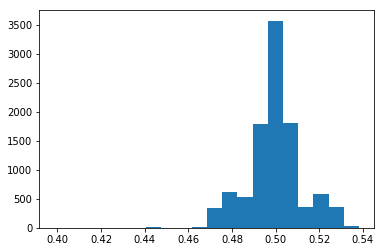

In [23]:
fig, ax = plt.subplots()
plt.hist(mc_theta, bins=200)
#ax.set_xlim(0.45, 0.55)